<div align="right">

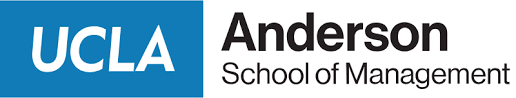

</div>

<div align="center">
<font size="5"><b>PRESCRIPTIVE MODELS AND DATA ANALYTICS</b></font>
<br>
<font size="5"><b>Problem Set #4</b></font>
<br>
This homework explores the use of Lasso for ad targeting using experimental data.
<br>
<br>
<font size="5"><b>Arnav Garg (906310841)</b></font>
</div>
<br>
<br>
<br>
<font size="4"><b>1 Simple Regression</b></font>
<br>
<br>
<font size="3.5"><b>1.1 Regression without controls</b></font>
<br>
<br>
<font size="3.5"><b>Question 1.</b> Load ad heterog data and regress revenue on treatment without further controls. The data is from an A/B test. Interpret the intercept and the treatment coefficient. </font>

The intercept coefficient means that a customer generates a revenue of $5.1082 for the business. The treatment coefficient means that a customer who viewed an ad generates an extra revenue of $0.6508 for the business.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load dataset
ad_heterog = pd.read_csv('ad_heterog.csv')

# Print the number of rows and columns
print(ad_heterog.shape)

# Print the first few rows
ad_heterog.head()

(2000, 32)


,revenue,treatment,demographic_1,demographic_2,demographic_3,demographic_4,demographic_5,demographic_6,demographic_7,demographic_8,...,demographic_21,demographic_22,demographic_23,demographic_24,demographic_25,demographic_26,demographic_27,demographic_28,demographic_29,demographic_30
0,5.504899,0,1,1,1,0,0,1,1,1,...,1,1,1,1,0,1,1,1,0,1
1,5.554275,1,0,1,1,0,0,0,1,0,...,0,0,0,1,1,0,1,1,1,0
2,5.219492,0,0,1,1,0,0,1,1,1,...,0,1,0,1,0,1,1,0,0,1
3,4.565855,0,1,0,0,0,1,1,0,1,...,1,0,0,1,0,1,0,0,1,0
4,5.020636,0,1,1,0,1,0,0,1,1,...,1,1,0,0,1,1,0,0,0,1


In [4]:
# Fit a linear regression model
model = ols('revenue ~ treatment', data = ad_heterog).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     779.2
Date:                Sat, 09 Mar 2024   Prob (F-statistic):          4.50e-145
Time:                        02:54:40   Log-Likelihood:                -1532.5
No. Observations:                2000   AIC:                             3069.
Df Residuals:                    1998   BIC:                             3080.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1082      0.016    315.942      0.0

<font size="3.5"><b>Question 2.</b> Assume that it costs 0.7 Dollars to show the ad. Based on the previous regression, should you show the ad (assuming you either show it to all consumers or to nobody, i.e. you are not able to target the ad)? </font>

The marginal revenue of an ad is $0.6508 and the marginal cost of an ad is $0.7. Since marginal cost is higher than marginal revenue, it makes no sense to show an ad because it's not profitable.

<font size="4"><b>2 Lasso with interactions</b></font>
<br>
<br>
Run the code below in order to generate a matrix of demographic variables as well as a matrix of interaction terms.

\# extract columns pertaining to demographic information (all columns except first two)
<br>
demo_matrix = ad_heterog.iloc[:,2:]

\# generate interactions of each demographic variable with the treatment variable
<br>
demo_treat_matrix = demo_matrix.multiply(ad_heterog[’treatment’], axis="index")
<br>
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")

\# generate treatment variable that is outside of data-frame (useful below)
<br>
treatment = ad_heterog[’treatment’]

In [39]:
demo_matrix = ad_heterog.iloc[:,1:]
demo_treat_matrix = demo_matrix.multiply(ad_heterog['treatment'], axis="index")
demo_treat_matrix.columns = demo_treat_matrix.columns.str.replace("demographic", "treat_demo")
treatment = ad_heterog['treatment']
revenue = ad_heterog['revenue']

In [14]:
from scipy import sparse
from sklearn import linear_model
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [11]:
def plot_lassoCV(lasso,nfolds):
     #1se rule 
    mean = np.mean(lasso.mse_path_, axis=1)
    std_error = np.std(lasso.mse_path_, axis=1)/np.sqrt(nfolds)
    mean_min  = mean[lasso.alphas_==lasso.alpha_]
    std_min   = std_error[lasso.alphas_==lasso.alpha_]
    alpha_1se = np.max(lasso.alphas_[mean <= mean_min + std_min])

    # Plot    
    plt.semilogx(lasso.alphas_, np.mean(lasso.mse_path_, axis=1))

    plt.semilogx(lasso.alphas_, mean + std_error, "b--")
    plt.semilogx(lasso.alphas_, mean - std_error, "b--")
    plt.fill_between(lasso.alphas_, mean + std_error, mean - std_error, alpha=0.2)
    plt.axvline(lasso.alpha_, linestyle="--", color="black", label="$\lambda_{min}$")
    plt.axvline(alpha_1se, linestyle="--", color="red", label="$\lambda_{1se}$")
    plt.legend()
    plt.xlabel("$\log(\lambda)$")
    plt.ylabel("Mean Squared Error")
    plt.show() 

<font size="3.5"><b>Question 1.</b> Run a lasso regression (not cross-validated yet) without standardization using treatment and the interaction term matrix as X variables (note that we are NOT also using the demographic variables as controls here). Plot how the coefficients behave when changing the penalty parameter. Why do you think the first line (from right to left) is non-monotonic (i.e. it first increases and then decreases)? </font>

xxx

Text(0.5, 1.0, 'Lasso coefficients as a function of alpha')

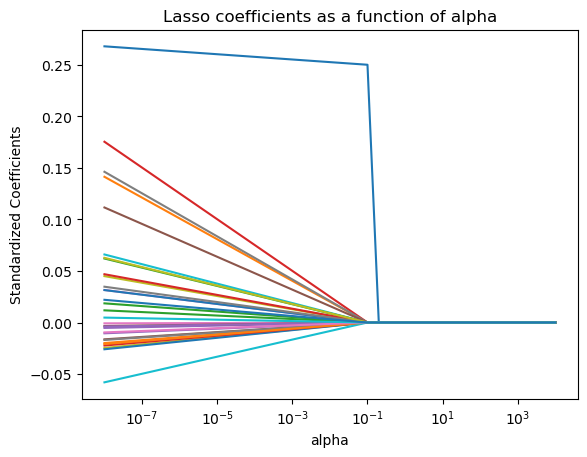

In [41]:
# X variables to try for LASSO
X = demo_treat_matrix.copy()

# Y variable for LASSO
Y = revenue.copy()

alphas = np.linspace(0.001,1000,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, Y)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')

In [24]:
lasso.coef_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

<font size="3.5"><b>Question 2.</b> Run the cross-validated lasso (without standardization) based on the same set of variables. Report the coefficient values for all non-zero coefficients at the optimal penalty value. What do the results suggest regarding the scope for targeting? </font>

xxx

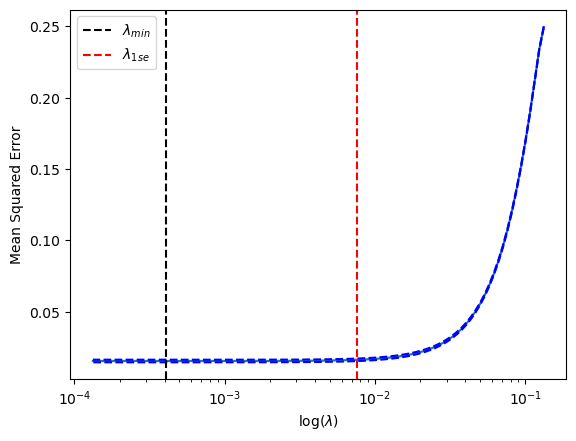

In [12]:
# X variables to try for LASSO
X = demo_treat_matrix.copy()

# Y variable for LASSO
Y = treatment.copy()

# We run CV Lasso
nfolds  = 10
lassocv = LassoCV(alphas = None, cv = nfolds, max_iter = 10000) 
lassocv.fit(X,Y)
plot_lassoCV(lassocv,nfolds)

<font size="4"><b>3 Lasso with baseline and interacted demographics</b></font>
<br>
<br>
<font size="3.5"><b>Question 1.</b> Run a cross-validated lasso based on the same variables as above, but now also include the un-interacted demographic variables to the matrix of X variables to try for lasso. Make sure you know how to interpret the coefficients for the demographics that are selected as both slope and intercept dummies as opposed to the demographics that only show up as interaction dummies. For example, consider the case of demographics 3 and 7. Can you compute the treatment effect for both characteristics (i.e., the effect of the treatment on individuals with a certain characteristic vs. individuals with the same characteristic in the control group?). </font>

xxx

<font size="3.5"><b>Question 2.</b> For each observation, compute predicted revenue without and with treatment. Use those two predictions to compute the expected profit per consumer when showing the ad to everybody versus when showing the ad only to consumers with positive expected profit. </font>

xxx